In [1]:
from settings import s, e
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle

from IPython.display import clear_output, display, update_display
import matplotlib.pyplot as plt


from simple import Game

from agent_code.tensor_agent.agent import TensorAgent
from agent_code.tensor_agent.hyperparameters import hp
from agent_code.tensor_agent.X import RelativeX2 as game_state_X

clear_output()

In [7]:
class Game:
    def __init__(self, coins, agents):
        self.shape = coins.shape
        self.agents = agents
        self.coins = coins
        self.steps = 0
        self.terminated = False
    
    @staticmethod
    def create_arena(shape, agent_names, coin_count=3):
        coins = np.zeros(shape)
        xs = np.random.choice(shape[0], coin_count)
        ys = np.random.choice(shape[1], coin_count)
        
        coins[xs, ys] = 1
        
        
        # Distribute starting positions
        xs = np.random.choice(shape[0], len(agent_names))
        ys = np.random.choice(shape[1], len(agent_names))
        agents = []
        for name in agent_names:
            x, y = np.random.choice(shape[0]), np.random.choice(shape[1])
            agents.append((x, y, name, 1, 0))
        
        return [coins, agents]
    
    def step(self, agent_actions, permutation=None):
        self.steps += 1

        if permutation is None:
            permutation = np.random.permutation(len(self.agents))

        step_score = {n: 0 for _,_,n,_,_ in self.agents}

        for j in range(len(self.agents)):
            agent = self.agents[permutation[j]]
            x, y, name, bombs_left, score = agent
            action = agent_actions[name]
            
            if action == 'DOWN' and self.tile_is_free(x, y+1):
                y += 1
            if action == 'UP' and self.tile_is_free(x, y-1):
                y -= 1
            if action == 'RIGHT' and self.tile_is_free(x+1, y):
                x += 1
            if action == 'LEFT' and self.tile_is_free(x-1, y):
                x -= 1
            
            self.agents[permutation[j]] = (x, y, name, bombs_left, score)
        
        
        for j in range(len(self.agents)):
            x, y, name, bombs_left, score = self.agents[j]
            if self.coins[x,y]==1:
                step_score[name]+=s.reward_coin
            self.coins[x,y]=0
        
        if np.all(self.coins == 0) or len(self.agents) == 0 or self.steps >= 10:
            self.terminated = True
        
        return step_score
    
    def get_X(self, x, y):
        X = np.zeros((self.shape[0] * 2 - 1, self.shape[1] * 2 - 1, 1))
        X[self.shape[0]-1-x:self.shape[0]*2-1-x, self.shape[1]-1-y:self.shape[1]*2-1-y, 0] = self.coins
        return X
        
    def tile_is_free(self, x, y):
        ax, ay = self.shape
        if x < 0 or x >= ax or y < 0 or y >= ay:
            return False
        return True
    

In [3]:
import numpy as np
import tensorflow as tf

import time
from copy import copy

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras import backend as K

from agent_code.tensor_agent.hyperparameters import hp

from agent_code.tensor_agent.loss import weighted_huber_loss, huber_loss
from agent_code.tensor_agent.layers import NoisyDense, VAMerge


def create_conv_net(shape):
    # Convolutional part of the network
    inputs = Input(shape=shape)
    x = Flatten()(inputs)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(64, activation='relu')(x)

    return inputs, outputs

def create_stream(x, D):
    
    s = NoisyDense(64, activation='relu')(x)
    s = NoisyDense(D, activation=None)(s)
    return s

def create_model(shape, D):
    # Create the convolutional network
    
    inputs, x = create_conv_net(shape=shape)
   
    # Dueling networks:
    # - Split the model into value stream and advantage stream
    v = create_stream(x, 1)
    a = create_stream(x, D)
    # - Merge streams
    outputs = VAMerge()([v, a])
    #outputs = Activation('relu')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model, inputs, outputs

class FullModel:
    def __init__(self, input_shape, D):
        self.input_shape = input_shape
        self.D = D

        #========================
        #  Define Model
        #========================

        # Define online and target models for Double Q-learning
        self.online, _, _ = create_model(input_shape, D)
        self.target, t_in, t_out = create_model(input_shape, D)

        
        #========================
        #  Define Training Update
        #========================
        action_holder = Input(shape=(1,), dtype='int32')  # in j=0,...,D-1
        reward_holder = Input(shape=(1,))
        weight_holder = Input(shape=(1,))
        
        # applies a mask to the outputs so that only the prediction for the chosen action is considered
        responsible_weight = tf.batch_gather(t_out, action_holder)
        
        loss = weighted_huber_loss(reward_holder, responsible_weight, weight_holder)
        tf.summary.scalar('loss', loss)
        tf.summary.scalar('reward', tf.reduce_mean(reward_holder))

        optimizer = tf.train.AdamOptimizer(hp.learning_rate, epsilon=hp.adam_epsilon)
        update = optimizer.minimize(loss)

        merged_summary = tf.summary.merge_all()

        self.summary = merged_summary
        self.train_writer = tf.summary.FileWriter(f'tf-board/train/{time.time()}',
                                      K.get_session().graph)
        
        self.errors=tf.abs(reward_holder-responsible_weight)
        self.input_ph = t_in
        self.t_out = t_out
        self.action_ph = action_holder
        self.reward_ph = reward_holder
        self.update_op = update
        self.weights = weight_holder

        self.steps = 0


    def update(self, inputs, actions, rewards, per_weights):
        sess = K.get_session()
        _, errors, summary = sess.run([self.update_op, self.errors, self.summary], feed_dict={
            self.input_ph: inputs,
            self.action_ph:actions,
            self.reward_ph:rewards,
            self.weights:per_weights
        })
        self.train_writer.add_summary(summary, self.steps)
        self.steps += 1
        return errors

    def update_online(self):
        self.online.set_weights(self.target.get_weights())

    def save(self, file='my_model.h5'):
        self.target.save(file)

    def load_weights(self, file='my_model.h5'):
        self.online.load_weights(file)
        self.target.load_weights(file)

    def clone(self, share_online=True):
        clone = copy(self)
        if not share_online:
            clone.online, _, _ = create_model(input_shape, D)

        return clone


In [4]:
hp.buffer_size = 4000
hp.target_network_period = 1000
hp.epsilon = 0.
hp.learning_rate=0.001

In [5]:
#from agent_code.tensor_agent.model import FullModel
choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
D = len(choices)
arena_shape = (3, 3)
input_shape = (arena_shape[0]*2-1, arena_shape[1]*2-1, 1)

K.clear_session()
model = FullModel(input_shape, D)

grads = tf.gradients(model.t_out, model.input_ph)

agents = {
    'tensor_agent': TensorAgent(input_shape, D, weights=None, model=model) # alt: weights='tensor_agent-model.h5'
}
train = {a: False for a in agents}
clear_output()

In [6]:

def get_valid_actions(x, y, game):
    # choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
    valid = np.ones((6))
    if not game.tile_is_free(x, y-1):
        valid[2] = 0 # UP invalid
    if not game.tile_is_free(x, y+1):
        valid[3] = 0 # DOWN invalid
    if not game.tile_is_free(x-1, y):
        valid[1] = 0 # LEFT invalid
    if not game.tile_is_free(x+1, y):
        valid[0] = 0 # RIGHT invalid

    valid[4] = 0
    valid[5] = 0
    return valid

In [8]:
d = display(f'Starting...', display_id='progress')

n_steps = 400000
game = None

train['tensor_agent'] = True
moving_reward = 0

for step in range(n_steps):
    if game is None:
        game = Game(*Game.create_arena(arena_shape, agents.keys(), coin_count=1))

    actions = {}
    Xs = {}
    for agent in game.agents:
        x, y, name, _, _ = agent
        
        Xs[name] = game.get_X(x, y)
        valid_actions = get_valid_actions(x, y, game)
        actions[name] = agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    rewards = game.step(actions_as_string)
    moving_reward = 0.99 * moving_reward + rewards['tensor_agent']

    for _, _, name, _, _ in game.agents:
        if train[name]:
            agents[name].reward_update([Xs[name], actions[name], rewards[name]-0.1])
    
    if game.terminated:
        for name, a in agents.items():
            a.end_of_episode(save='tensor_agent-model.h5') # alt: save=None
        
        d.update(f'Step: {step+1}/{n_steps} Trained: {model.steps} Moving Reward: {moving_reward}')
        
        game = None

d.update(f'Complete')

'Step: 25905/400000 Trained: 6226 Moving Reward: 25.1395988333864'

End of episode. Steps: 1. Trained: 0
End of episode. Steps: 11. Trained: 0
End of episode. Steps: 20. Trained: 0
End of episode. Steps: 30. Trained: 0
End of episode. Steps: 36. Trained: 0
End of episode. Steps: 38. Trained: 0
End of episode. Steps: 40. Trained: 0
End of episode. Steps: 50. Trained: 0
End of episode. Steps: 52. Trained: 0
End of episode. Steps: 62. Trained: 0
End of episode. Steps: 63. Trained: 0
End of episode. Steps: 68. Trained: 0
End of episode. Steps: 78. Trained: 0
End of episode. Steps: 80. Trained: 0
End of episode. Steps: 90. Trained: 0
End of episode. Steps: 91. Trained: 0
End of episode. Steps: 94. Trained: 0
End of episode. Steps: 96. Trained: 0
End of episode. Steps: 100. Trained: 0
End of episode. Steps: 106. Trained: 0
End of episode. Steps: 116. Trained: 0
End of episode. Steps: 126. Trained: 0
End of episode. Steps: 136. Trained: 0
End of episode. Steps: 143. Trained: 0
End of episode. Steps: 144. Trained: 0
End of episode. Steps: 147. Trained: 0
End o

End of episode. Steps: 1385. Trained: 96
End of episode. Steps: 1395. Trained: 98
End of episode. Steps: 1400. Trained: 100
End of episode. Steps: 1404. Trained: 101
End of episode. Steps: 1408. Trained: 102
End of episode. Steps: 1418. Trained: 104
End of episode. Steps: 1428. Trained: 107
End of episode. Steps: 1438. Trained: 109
End of episode. Steps: 1439. Trained: 109
End of episode. Steps: 1441. Trained: 110
End of episode. Steps: 1451. Trained: 112
End of episode. Steps: 1455. Trained: 113
End of episode. Steps: 1457. Trained: 114
End of episode. Steps: 1467. Trained: 116
End of episode. Steps: 1477. Trained: 119
End of episode. Steps: 1487. Trained: 121
End of episode. Steps: 1491. Trained: 122
End of episode. Steps: 1493. Trained: 123
End of episode. Steps: 1494. Trained: 123
End of episode. Steps: 1496. Trained: 124
End of episode. Steps: 1505. Trained: 126
End of episode. Steps: 1515. Trained: 128
End of episode. Steps: 1522. Trained: 130
End of episode. Steps: 1532. Trained

End of episode. Steps: 2415. Trained: 353
End of episode. Steps: 2425. Trained: 356
End of episode. Steps: 2430. Trained: 357
End of episode. Steps: 2433. Trained: 358
End of episode. Steps: 2437. Trained: 359
End of episode. Steps: 2439. Trained: 359
End of episode. Steps: 2449. Trained: 362
End of episode. Steps: 2451. Trained: 362
End of episode. Steps: 2452. Trained: 363
End of episode. Steps: 2460. Trained: 365
End of episode. Steps: 2464. Trained: 366
End of episode. Steps: 2465. Trained: 366
End of episode. Steps: 2466. Trained: 366
End of episode. Steps: 2471. Trained: 367
End of episode. Steps: 2481. Trained: 370
End of episode. Steps: 2482. Trained: 370
End of episode. Steps: 2484. Trained: 371
End of episode. Steps: 2487. Trained: 371
End of episode. Steps: 2488. Trained: 372
End of episode. Steps: 2490. Trained: 372
End of episode. Steps: 2499. Trained: 374
End of episode. Steps: 2504. Trained: 376
End of episode. Steps: 2506. Trained: 376
End of episode. Steps: 2514. Train

End of episode. Steps: 3207. Trained: 551
End of episode. Steps: 3209. Trained: 552
End of episode. Steps: 3214. Trained: 553
End of episode. Steps: 3216. Trained: 554
End of episode. Steps: 3218. Trained: 554
End of episode. Steps: 3220. Trained: 555
End of episode. Steps: 3223. Trained: 555
End of episode. Steps: 3224. Trained: 556
End of episode. Steps: 3225. Trained: 556
End of episode. Steps: 3228. Trained: 557
End of episode. Steps: 3229. Trained: 557
End of episode. Steps: 3231. Trained: 557
End of episode. Steps: 3236. Trained: 559
End of episode. Steps: 3240. Trained: 560
End of episode. Steps: 3245. Trained: 561
End of episode. Steps: 3255. Trained: 563
End of episode. Steps: 3265. Trained: 566
End of episode. Steps: 3267. Trained: 566
End of episode. Steps: 3277. Trained: 569
End of episode. Steps: 3281. Trained: 570
End of episode. Steps: 3283. Trained: 570
End of episode. Steps: 3290. Trained: 572
End of episode. Steps: 3291. Trained: 572
End of episode. Steps: 3292. Train

End of episode. Steps: 4019. Trained: 754
End of episode. Steps: 4029. Trained: 757
End of episode. Steps: 4031. Trained: 757
End of episode. Steps: 4032. Trained: 758
End of episode. Steps: 4033. Trained: 758
End of episode. Steps: 4034. Trained: 758
End of episode. Steps: 4036. Trained: 759
End of episode. Steps: 4038. Trained: 759
End of episode. Steps: 4048. Trained: 762
End of episode. Steps: 4058. Trained: 764
End of episode. Steps: 4063. Trained: 765
End of episode. Steps: 4071. Trained: 767
End of episode. Steps: 4075. Trained: 768
End of episode. Steps: 4077. Trained: 769
End of episode. Steps: 4078. Trained: 769
End of episode. Steps: 4088. Trained: 772
End of episode. Steps: 4090. Trained: 772
End of episode. Steps: 4093. Trained: 773
End of episode. Steps: 4094. Trained: 773
End of episode. Steps: 4104. Trained: 776
End of episode. Steps: 4105. Trained: 776
End of episode. Steps: 4107. Trained: 776
End of episode. Steps: 4109. Trained: 777
End of episode. Steps: 4119. Train

End of episode. Steps: 4893. Trained: 973
End of episode. Steps: 4903. Trained: 975
End of episode. Steps: 4904. Trained: 976
End of episode. Steps: 4905. Trained: 976
End of episode. Steps: 4907. Trained: 976
End of episode. Steps: 4909. Trained: 977
End of episode. Steps: 4914. Trained: 978
End of episode. Steps: 4916. Trained: 979
End of episode. Steps: 4923. Trained: 980
End of episode. Steps: 4932. Trained: 983
End of episode. Steps: 4934. Trained: 983
End of episode. Steps: 4935. Trained: 983
End of episode. Steps: 4945. Trained: 986
End of episode. Steps: 4955. Trained: 988
End of episode. Steps: 4965. Trained: 991
End of episode. Steps: 4968. Trained: 992
End of episode. Steps: 4978. Trained: 994
End of episode. Steps: 4988. Trained: 997
End of episode. Steps: 4989. Trained: 997
End of episode. Steps: 4993. Trained: 998
End of episode. Steps: 5001. Trained: 1000
End of episode. Steps: 5003. Trained: 1000
End of episode. Steps: 5005. Trained: 1001
End of episode. Steps: 5007. Tr

End of episode. Steps: 5625. Trained: 1156
End of episode. Steps: 5627. Trained: 1156
End of episode. Steps: 5633. Trained: 1158
End of episode. Steps: 5635. Trained: 1158
End of episode. Steps: 5645. Trained: 1161
End of episode. Steps: 5655. Trained: 1163
End of episode. Steps: 5657. Trained: 1164
End of episode. Steps: 5659. Trained: 1164
End of episode. Steps: 5660. Trained: 1165
End of episode. Steps: 5662. Trained: 1165
End of episode. Steps: 5672. Trained: 1168
End of episode. Steps: 5682. Trained: 1170
End of episode. Steps: 5684. Trained: 1171
End of episode. Steps: 5688. Trained: 1172
End of episode. Steps: 5689. Trained: 1172
End of episode. Steps: 5695. Trained: 1173
End of episode. Steps: 5705. Trained: 1176
End of episode. Steps: 5708. Trained: 1177
End of episode. Steps: 5714. Trained: 1178
End of episode. Steps: 5717. Trained: 1179
End of episode. Steps: 5722. Trained: 1180
End of episode. Steps: 5724. Trained: 1181
End of episode. Steps: 5725. Trained: 1181
End of epis

End of episode. Steps: 6512. Trained: 1378
End of episode. Steps: 6514. Trained: 1378
End of episode. Steps: 6524. Trained: 1381
End of episode. Steps: 6534. Trained: 1383
End of episode. Steps: 6544. Trained: 1386
End of episode. Steps: 6554. Trained: 1388
End of episode. Steps: 6556. Trained: 1389
End of episode. Steps: 6558. Trained: 1389
End of episode. Steps: 6560. Trained: 1390
End of episode. Steps: 6561. Trained: 1390
End of episode. Steps: 6571. Trained: 1392
End of episode. Steps: 6581. Trained: 1395
End of episode. Steps: 6584. Trained: 1396
End of episode. Steps: 6594. Trained: 1398
End of episode. Steps: 6595. Trained: 1398
End of episode. Steps: 6604. Trained: 1401
End of episode. Steps: 6607. Trained: 1401
End of episode. Steps: 6609. Trained: 1402
End of episode. Steps: 6619. Trained: 1404
End of episode. Steps: 6629. Trained: 1407
End of episode. Steps: 6639. Trained: 1409
End of episode. Steps: 6640. Trained: 1410
End of episode. Steps: 6650. Trained: 1412
End of epis

End of episode. Steps: 7471. Trained: 1617
End of episode. Steps: 7481. Trained: 1620
End of episode. Steps: 7482. Trained: 1620
End of episode. Steps: 7487. Trained: 1621
End of episode. Steps: 7494. Trained: 1623
End of episode. Steps: 7497. Trained: 1624
End of episode. Steps: 7499. Trained: 1624
End of episode. Steps: 7504. Trained: 1626
End of episode. Steps: 7514. Trained: 1628
End of episode. Steps: 7516. Trained: 1629
End of episode. Steps: 7526. Trained: 1631
End of episode. Steps: 7533. Trained: 1633
End of episode. Steps: 7534. Trained: 1633
End of episode. Steps: 7544. Trained: 1636
End of episode. Steps: 7546. Trained: 1636
End of episode. Steps: 7547. Trained: 1636
End of episode. Steps: 7548. Trained: 1637
End of episode. Steps: 7554. Trained: 1638
End of episode. Steps: 7556. Trained: 1639
End of episode. Steps: 7566. Trained: 1641
End of episode. Steps: 7573. Trained: 1643
End of episode. Steps: 7575. Trained: 1643
End of episode. Steps: 7585. Trained: 1646
End of epis

End of episode. Steps: 8354. Trained: 1838
End of episode. Steps: 8355. Trained: 1838
End of episode. Steps: 8365. Trained: 1841
End of episode. Steps: 8366. Trained: 1841
End of episode. Steps: 8368. Trained: 1842
End of episode. Steps: 8369. Trained: 1842
End of episode. Steps: 8370. Trained: 1842
End of episode. Steps: 8380. Trained: 1845
End of episode. Steps: 8387. Trained: 1846
End of episode. Steps: 8389. Trained: 1847
End of episode. Steps: 8392. Trained: 1848
End of episode. Steps: 8394. Trained: 1848
End of episode. Steps: 8397. Trained: 1849
End of episode. Steps: 8402. Trained: 1850
End of episode. Steps: 8404. Trained: 1851
End of episode. Steps: 8406. Trained: 1851
End of episode. Steps: 8412. Trained: 1853
End of episode. Steps: 8414. Trained: 1853
End of episode. Steps: 8416. Trained: 1854
End of episode. Steps: 8425. Trained: 1856
End of episode. Steps: 8428. Trained: 1857
End of episode. Steps: 8430. Trained: 1857
End of episode. Steps: 8435. Trained: 1858
End of epis

End of episode. Steps: 9101. Trained: 2025
End of episode. Steps: 9111. Trained: 2027
End of episode. Steps: 9112. Trained: 2028
End of episode. Steps: 9116. Trained: 2029
End of episode. Steps: 9123. Trained: 2030
End of episode. Steps: 9126. Trained: 2031
End of episode. Steps: 9136. Trained: 2034
End of episode. Steps: 9137. Trained: 2034
End of episode. Steps: 9138. Trained: 2034
End of episode. Steps: 9141. Trained: 2035
End of episode. Steps: 9143. Trained: 2035
End of episode. Steps: 9152. Trained: 2038
End of episode. Steps: 9162. Trained: 2040
End of episode. Steps: 9163. Trained: 2040
End of episode. Steps: 9173. Trained: 2043
End of episode. Steps: 9176. Trained: 2044
End of episode. Steps: 9179. Trained: 2044
End of episode. Steps: 9186. Trained: 2046
End of episode. Steps: 9188. Trained: 2047
End of episode. Steps: 9189. Trained: 2047
End of episode. Steps: 9191. Trained: 2047
End of episode. Steps: 9193. Trained: 2048
End of episode. Steps: 9195. Trained: 2048
End of epis

End of episode. Steps: 10010. Trained: 2252
End of episode. Steps: 10020. Trained: 2255
End of episode. Steps: 10021. Trained: 2255
End of episode. Steps: 10029. Trained: 2257
End of episode. Steps: 10033. Trained: 2258
End of episode. Steps: 10035. Trained: 2258
End of episode. Steps: 10036. Trained: 2259
End of episode. Steps: 10038. Trained: 2259
End of episode. Steps: 10040. Trained: 2260
End of episode. Steps: 10042. Trained: 2260
End of episode. Steps: 10046. Trained: 2261
End of episode. Steps: 10047. Trained: 2261
End of episode. Steps: 10049. Trained: 2262
End of episode. Steps: 10059. Trained: 2264
End of episode. Steps: 10061. Trained: 2265
End of episode. Steps: 10065. Trained: 2266
End of episode. Steps: 10075. Trained: 2268
End of episode. Steps: 10076. Trained: 2269
End of episode. Steps: 10086. Trained: 2271
End of episode. Steps: 10088. Trained: 2272
End of episode. Steps: 10098. Trained: 2274
End of episode. Steps: 10106. Trained: 2276
End of episode. Steps: 10114. Tr

End of episode. Steps: 10889. Trained: 2472
End of episode. Steps: 10899. Trained: 2474
End of episode. Steps: 10901. Trained: 2475
End of episode. Steps: 10902. Trained: 2475
End of episode. Steps: 10903. Trained: 2475
End of episode. Steps: 10904. Trained: 2476
End of episode. Steps: 10914. Trained: 2478
End of episode. Steps: 10919. Trained: 2479
End of episode. Steps: 10929. Trained: 2482
End of episode. Steps: 10939. Trained: 2484
End of episode. Steps: 10946. Trained: 2486
End of episode. Steps: 10947. Trained: 2486
End of episode. Steps: 10949. Trained: 2487
End of episode. Steps: 10959. Trained: 2489
End of episode. Steps: 10969. Trained: 2492
End of episode. Steps: 10971. Trained: 2492
End of episode. Steps: 10973. Trained: 2493
End of episode. Steps: 10983. Trained: 2495
End of episode. Steps: 10985. Trained: 2496
End of episode. Steps: 10995. Trained: 2498
End of episode. Steps: 10996. Trained: 2499
End of episode. Steps: 11006. Trained: 2501
End of episode. Steps: 11016. Tr

End of episode. Steps: 11765. Trained: 2691
End of episode. Steps: 11775. Trained: 2693
End of episode. Steps: 11776. Trained: 2694
End of episode. Steps: 11786. Trained: 2696
End of episode. Steps: 11796. Trained: 2699
End of episode. Steps: 11797. Trained: 2699
End of episode. Steps: 11798. Trained: 2699
End of episode. Steps: 11800. Trained: 2700
End of episode. Steps: 11810. Trained: 2702
End of episode. Steps: 11820. Trained: 2705
End of episode. Steps: 11823. Trained: 2705
End of episode. Steps: 11824. Trained: 2706
End of episode. Steps: 11826. Trained: 2706
End of episode. Steps: 11836. Trained: 2709
End of episode. Steps: 11838. Trained: 2709
End of episode. Steps: 11846. Trained: 2711
End of episode. Steps: 11848. Trained: 2712
End of episode. Steps: 11858. Trained: 2714
End of episode. Steps: 11860. Trained: 2715
End of episode. Steps: 11868. Trained: 2717
End of episode. Steps: 11870. Trained: 2717
End of episode. Steps: 11880. Trained: 2720
End of episode. Steps: 11881. Tr

End of episode. Steps: 12677. Trained: 2919
End of episode. Steps: 12679. Trained: 2919
End of episode. Steps: 12689. Trained: 2922
End of episode. Steps: 12690. Trained: 2922
End of episode. Steps: 12696. Trained: 2924
End of episode. Steps: 12699. Trained: 2924
End of episode. Steps: 12704. Trained: 2926
End of episode. Steps: 12714. Trained: 2928
End of episode. Steps: 12717. Trained: 2929
End of episode. Steps: 12722. Trained: 2930
End of episode. Steps: 12723. Trained: 2930
End of episode. Steps: 12724. Trained: 2931
End of episode. Steps: 12726. Trained: 2931
End of episode. Steps: 12728. Trained: 2932
End of episode. Steps: 12730. Trained: 2932
End of episode. Steps: 12740. Trained: 2935
End of episode. Steps: 12742. Trained: 2935
End of episode. Steps: 12744. Trained: 2936
End of episode. Steps: 12748. Trained: 2937
End of episode. Steps: 12757. Trained: 2939
End of episode. Steps: 12758. Trained: 2939
End of episode. Steps: 12760. Trained: 2940
End of episode. Steps: 12768. Tr

End of episode. Steps: 13494. Trained: 3123
End of episode. Steps: 13502. Trained: 3125
End of episode. Steps: 13506. Trained: 3126
End of episode. Steps: 13510. Trained: 3127
End of episode. Steps: 13511. Trained: 3127
End of episode. Steps: 13513. Trained: 3128
End of episode. Steps: 13515. Trained: 3128
End of episode. Steps: 13519. Trained: 3129
End of episode. Steps: 13522. Trained: 3130
End of episode. Steps: 13532. Trained: 3133
End of episode. Steps: 13537. Trained: 3134
End of episode. Steps: 13547. Trained: 3136
End of episode. Steps: 13549. Trained: 3137
End of episode. Steps: 13551. Trained: 3137
End of episode. Steps: 13556. Trained: 3139
End of episode. Steps: 13562. Trained: 3140
End of episode. Steps: 13572. Trained: 3143
End of episode. Steps: 13578. Trained: 3144
End of episode. Steps: 13588. Trained: 3147
End of episode. Steps: 13589. Trained: 3147
End of episode. Steps: 13590. Trained: 3147
End of episode. Steps: 13593. Trained: 3148
End of episode. Steps: 13603. Tr

End of episode. Steps: 14296. Trained: 3324
End of episode. Steps: 14305. Trained: 3326
End of episode. Steps: 14307. Trained: 3326
End of episode. Steps: 14308. Trained: 3327
End of episode. Steps: 14312. Trained: 3328
End of episode. Steps: 14322. Trained: 3330
End of episode. Steps: 14324. Trained: 3331
End of episode. Steps: 14325. Trained: 3331
End of episode. Steps: 14326. Trained: 3331
End of episode. Steps: 14327. Trained: 3331
End of episode. Steps: 14330. Trained: 3332
End of episode. Steps: 14331. Trained: 3332
End of episode. Steps: 14334. Trained: 3333
End of episode. Steps: 14336. Trained: 3334
End of episode. Steps: 14337. Trained: 3334
End of episode. Steps: 14341. Trained: 3335
End of episode. Steps: 14344. Trained: 3336
End of episode. Steps: 14348. Trained: 3337
End of episode. Steps: 14354. Trained: 3338
End of episode. Steps: 14363. Trained: 3340
End of episode. Steps: 14365. Trained: 3341
End of episode. Steps: 14375. Trained: 3343
End of episode. Steps: 14378. Tr

End of episode. Steps: 15080. Trained: 3520
End of episode. Steps: 15086. Trained: 3521
End of episode. Steps: 15095. Trained: 3523
End of episode. Steps: 15100. Trained: 3525
End of episode. Steps: 15103. Trained: 3525
End of episode. Steps: 15112. Trained: 3528
End of episode. Steps: 15122. Trained: 3530
End of episode. Steps: 15132. Trained: 3533
End of episode. Steps: 15134. Trained: 3533
End of episode. Steps: 15136. Trained: 3534
End of episode. Steps: 15137. Trained: 3534
End of episode. Steps: 15138. Trained: 3534
End of episode. Steps: 15140. Trained: 3535
End of episode. Steps: 15142. Trained: 3535
End of episode. Steps: 15146. Trained: 3536
End of episode. Steps: 15148. Trained: 3537
End of episode. Steps: 15149. Trained: 3537
End of episode. Steps: 15151. Trained: 3537
End of episode. Steps: 15152. Trained: 3538
End of episode. Steps: 15154. Trained: 3538
End of episode. Steps: 15158. Trained: 3539
End of episode. Steps: 15160. Trained: 3540
End of episode. Steps: 15162. Tr

End of episode. Steps: 15865. Trained: 3716
End of episode. Steps: 15867. Trained: 3716
End of episode. Steps: 15874. Trained: 3718
End of episode. Steps: 15875. Trained: 3718
End of episode. Steps: 15883. Trained: 3720
End of episode. Steps: 15885. Trained: 3721
End of episode. Steps: 15888. Trained: 3722
End of episode. Steps: 15898. Trained: 3724
End of episode. Steps: 15902. Trained: 3725
End of episode. Steps: 15912. Trained: 3728
End of episode. Steps: 15921. Trained: 3730
End of episode. Steps: 15926. Trained: 3731
End of episode. Steps: 15930. Trained: 3732
End of episode. Steps: 15931. Trained: 3732
End of episode. Steps: 15933. Trained: 3733
End of episode. Steps: 15943. Trained: 3735
End of episode. Steps: 15944. Trained: 3736
End of episode. Steps: 15947. Trained: 3736
End of episode. Steps: 15953. Trained: 3738
End of episode. Steps: 15955. Trained: 3738
End of episode. Steps: 15959. Trained: 3739
End of episode. Steps: 15969. Trained: 3742
End of episode. Steps: 15974. Tr

End of episode. Steps: 16655. Trained: 3913
End of episode. Steps: 16657. Trained: 3914
End of episode. Steps: 16659. Trained: 3914
End of episode. Steps: 16669. Trained: 3917
End of episode. Steps: 16671. Trained: 3917
End of episode. Steps: 16674. Trained: 3918
End of episode. Steps: 16677. Trained: 3919
End of episode. Steps: 16678. Trained: 3919
End of episode. Steps: 16679. Trained: 3919
End of episode. Steps: 16681. Trained: 3920
End of episode. Steps: 16686. Trained: 3921
End of episode. Steps: 16696. Trained: 3924
End of episode. Steps: 16700. Trained: 3925
End of episode. Steps: 16702. Trained: 3925
End of episode. Steps: 16712. Trained: 3928
End of episode. Steps: 16715. Trained: 3928
End of episode. Steps: 16725. Trained: 3931
End of episode. Steps: 16727. Trained: 3931
End of episode. Steps: 16729. Trained: 3932
End of episode. Steps: 16731. Trained: 3932
End of episode. Steps: 16735. Trained: 3933
End of episode. Steps: 16738. Trained: 3934
End of episode. Steps: 16739. Tr

End of episode. Steps: 17302. Trained: 4075
End of episode. Steps: 17306. Trained: 4076
End of episode. Steps: 17308. Trained: 4077
End of episode. Steps: 17318. Trained: 4079
End of episode. Steps: 17321. Trained: 4080
End of episode. Steps: 17331. Trained: 4082
End of episode. Steps: 17335. Trained: 4083
End of episode. Steps: 17336. Trained: 4084
End of episode. Steps: 17337. Trained: 4084
End of episode. Steps: 17345. Trained: 4086
End of episode. Steps: 17346. Trained: 4086
End of episode. Steps: 17347. Trained: 4086
End of episode. Steps: 17350. Trained: 4087
End of episode. Steps: 17353. Trained: 4088
End of episode. Steps: 17357. Trained: 4089
End of episode. Steps: 17361. Trained: 4090
End of episode. Steps: 17365. Trained: 4091
End of episode. Steps: 17367. Trained: 4091
End of episode. Steps: 17371. Trained: 4092
End of episode. Steps: 17379. Trained: 4094
End of episode. Steps: 17387. Trained: 4096
End of episode. Steps: 17395. Trained: 4098
End of episode. Steps: 17398. Tr

End of episode. Steps: 18042. Trained: 4260
End of episode. Steps: 18044. Trained: 4261
End of episode. Steps: 18046. Trained: 4261
End of episode. Steps: 18051. Trained: 4262
End of episode. Steps: 18053. Trained: 4263
End of episode. Steps: 18057. Trained: 4264
End of episode. Steps: 18059. Trained: 4264
End of episode. Steps: 18062. Trained: 4265
End of episode. Steps: 18069. Trained: 4267
End of episode. Steps: 18079. Trained: 4269
End of episode. Steps: 18089. Trained: 4272
End of episode. Steps: 18091. Trained: 4272
End of episode. Steps: 18092. Trained: 4273
End of episode. Steps: 18094. Trained: 4273
End of episode. Steps: 18103. Trained: 4275
End of episode. Steps: 18105. Trained: 4276
End of episode. Steps: 18110. Trained: 4277
End of episode. Steps: 18115. Trained: 4278
End of episode. Steps: 18116. Trained: 4279
End of episode. Steps: 18118. Trained: 4279
End of episode. Steps: 18122. Trained: 4280
End of episode. Steps: 18123. Trained: 4280
End of episode. Steps: 18130. Tr

End of episode. Steps: 18825. Trained: 4456
End of episode. Steps: 18831. Trained: 4457
End of episode. Steps: 18833. Trained: 4458
End of episode. Steps: 18843. Trained: 4460
End of episode. Steps: 18853. Trained: 4463
End of episode. Steps: 18855. Trained: 4463
End of episode. Steps: 18857. Trained: 4464
End of episode. Steps: 18859. Trained: 4464
End of episode. Steps: 18860. Trained: 4465
End of episode. Steps: 18861. Trained: 4465
End of episode. Steps: 18863. Trained: 4465
End of episode. Steps: 18868. Trained: 4467
End of episode. Steps: 18873. Trained: 4468
End of episode. Steps: 18874. Trained: 4468
End of episode. Steps: 18875. Trained: 4468
End of episode. Steps: 18877. Trained: 4469
End of episode. Steps: 18887. Trained: 4471
End of episode. Steps: 18889. Trained: 4472
End of episode. Steps: 18891. Trained: 4472
End of episode. Steps: 18897. Trained: 4474
End of episode. Steps: 18901. Trained: 4475
End of episode. Steps: 18911. Trained: 4477
End of episode. Steps: 18913. Tr

End of episode. Steps: 19647. Trained: 4661
End of episode. Steps: 19656. Trained: 4664
End of episode. Steps: 19657. Trained: 4664
End of episode. Steps: 19667. Trained: 4666
End of episode. Steps: 19668. Trained: 4667
End of episode. Steps: 19671. Trained: 4667
End of episode. Steps: 19674. Trained: 4668
End of episode. Steps: 19680. Trained: 4670
End of episode. Steps: 19681. Trained: 4670
End of episode. Steps: 19682. Trained: 4670
End of episode. Steps: 19686. Trained: 4671
End of episode. Steps: 19688. Trained: 4672
End of episode. Steps: 19698. Trained: 4674
End of episode. Steps: 19702. Trained: 4675
End of episode. Steps: 19704. Trained: 4676
End of episode. Steps: 19714. Trained: 4678
End of episode. Steps: 19715. Trained: 4678
End of episode. Steps: 19725. Trained: 4681
End of episode. Steps: 19728. Trained: 4682
End of episode. Steps: 19731. Trained: 4682
End of episode. Steps: 19734. Trained: 4683
End of episode. Steps: 19735. Trained: 4683
End of episode. Steps: 19736. Tr

End of episode. Steps: 20388. Trained: 4847
End of episode. Steps: 20398. Trained: 4849
End of episode. Steps: 20399. Trained: 4849
End of episode. Steps: 20401. Trained: 4850
End of episode. Steps: 20403. Trained: 4850
End of episode. Steps: 20405. Trained: 4851
End of episode. Steps: 20407. Trained: 4851
End of episode. Steps: 20414. Trained: 4853
End of episode. Steps: 20416. Trained: 4854
End of episode. Steps: 20426. Trained: 4856
End of episode. Steps: 20428. Trained: 4857
End of episode. Steps: 20430. Trained: 4857
End of episode. Steps: 20439. Trained: 4859
End of episode. Steps: 20449. Trained: 4862
End of episode. Steps: 20450. Trained: 4862
End of episode. Steps: 20452. Trained: 4863
End of episode. Steps: 20454. Trained: 4863
End of episode. Steps: 20457. Trained: 4864
End of episode. Steps: 20461. Trained: 4865
End of episode. Steps: 20462. Trained: 4865
End of episode. Steps: 20464. Trained: 4866
End of episode. Steps: 20465. Trained: 4866
End of episode. Steps: 20471. Tr

End of episode. Steps: 21109. Trained: 5027
End of episode. Steps: 21111. Trained: 5027
End of episode. Steps: 21112. Trained: 5028
End of episode. Steps: 21113. Trained: 5028
End of episode. Steps: 21115. Trained: 5028
End of episode. Steps: 21116. Trained: 5029
End of episode. Steps: 21117. Trained: 5029
End of episode. Steps: 21119. Trained: 5029
End of episode. Steps: 21122. Trained: 5030
End of episode. Steps: 21123. Trained: 5030
End of episode. Steps: 21125. Trained: 5031
End of episode. Steps: 21130. Trained: 5032
End of episode. Steps: 21137. Trained: 5034
End of episode. Steps: 21145. Trained: 5036
End of episode. Steps: 21153. Trained: 5038
End of episode. Steps: 21158. Trained: 5039
End of episode. Steps: 21159. Trained: 5039
End of episode. Steps: 21166. Trained: 5041
End of episode. Steps: 21170. Trained: 5042
End of episode. Steps: 21172. Trained: 5043
End of episode. Steps: 21174. Trained: 5043
End of episode. Steps: 21176. Trained: 5044
End of episode. Steps: 21179. Tr

End of episode. Steps: 21819. Trained: 5204
End of episode. Steps: 21829. Trained: 5207
End of episode. Steps: 21830. Trained: 5207
End of episode. Steps: 21834. Trained: 5208
End of episode. Steps: 21844. Trained: 5211
End of episode. Steps: 21847. Trained: 5211
End of episode. Steps: 21848. Trained: 5212
End of episode. Steps: 21858. Trained: 5214
End of episode. Steps: 21861. Trained: 5215
End of episode. Steps: 21867. Trained: 5216
End of episode. Steps: 21870. Trained: 5217
End of episode. Steps: 21874. Trained: 5218
End of episode. Steps: 21878. Trained: 5219
End of episode. Steps: 21882. Trained: 5220
End of episode. Steps: 21886. Trained: 5221
End of episode. Steps: 21888. Trained: 5222
End of episode. Steps: 21898. Trained: 5224
End of episode. Steps: 21899. Trained: 5224
End of episode. Steps: 21903. Trained: 5225
End of episode. Steps: 21907. Trained: 5226
End of episode. Steps: 21912. Trained: 5228
End of episode. Steps: 21914. Trained: 5228
End of episode. Steps: 21915. Tr

End of episode. Steps: 22579. Trained: 5394
End of episode. Steps: 22580. Trained: 5395
End of episode. Steps: 22581. Trained: 5395
End of episode. Steps: 22585. Trained: 5396
End of episode. Steps: 22591. Trained: 5397
End of episode. Steps: 22593. Trained: 5398
End of episode. Steps: 22595. Trained: 5398
End of episode. Steps: 22605. Trained: 5401
End of episode. Steps: 22607. Trained: 5401
End of episode. Steps: 22617. Trained: 5404
End of episode. Steps: 22619. Trained: 5404
End of episode. Steps: 22620. Trained: 5405
End of episode. Steps: 22630. Trained: 5407
End of episode. Steps: 22640. Trained: 5410
End of episode. Steps: 22644. Trained: 5411
End of episode. Steps: 22646. Trained: 5411
End of episode. Steps: 22648. Trained: 5412
End of episode. Steps: 22658. Trained: 5414
End of episode. Steps: 22660. Trained: 5415
End of episode. Steps: 22662. Trained: 5415
End of episode. Steps: 22663. Trained: 5415
End of episode. Steps: 22673. Trained: 5418
End of episode. Steps: 22676. Tr

End of episode. Steps: 23361. Trained: 5590
End of episode. Steps: 23367. Trained: 5591
End of episode. Steps: 23373. Trained: 5593
End of episode. Steps: 23374. Trained: 5593
End of episode. Steps: 23384. Trained: 5596
End of episode. Steps: 23386. Trained: 5596
End of episode. Steps: 23392. Trained: 5598
End of episode. Steps: 23394. Trained: 5598
End of episode. Steps: 23402. Trained: 5600
End of episode. Steps: 23407. Trained: 5601
End of episode. Steps: 23417. Trained: 5604
End of episode. Steps: 23418. Trained: 5604
End of episode. Steps: 23426. Trained: 5606
End of episode. Steps: 23430. Trained: 5607
End of episode. Steps: 23433. Trained: 5608
End of episode. Steps: 23443. Trained: 5610
End of episode. Steps: 23449. Trained: 5612
End of episode. Steps: 23458. Trained: 5614
End of episode. Steps: 23460. Trained: 5615
End of episode. Steps: 23468. Trained: 5617
End of episode. Steps: 23478. Trained: 5619
End of episode. Steps: 23488. Trained: 5622
End of episode. Steps: 23489. Tr

End of episode. Steps: 24199. Trained: 5799
End of episode. Steps: 24201. Trained: 5800
End of episode. Steps: 24205. Trained: 5801
End of episode. Steps: 24206. Trained: 5801
End of episode. Steps: 24208. Trained: 5802
End of episode. Steps: 24211. Trained: 5802
End of episode. Steps: 24212. Trained: 5803
End of episode. Steps: 24213. Trained: 5803
End of episode. Steps: 24215. Trained: 5803
End of episode. Steps: 24225. Trained: 5806
End of episode. Steps: 24227. Trained: 5806
End of episode. Steps: 24233. Trained: 5808
End of episode. Steps: 24239. Trained: 5809
End of episode. Steps: 24240. Trained: 5810
End of episode. Steps: 24242. Trained: 5810
End of episode. Steps: 24245. Trained: 5811
End of episode. Steps: 24253. Trained: 5813
End of episode. Steps: 24263. Trained: 5815
End of episode. Steps: 24265. Trained: 5816
End of episode. Steps: 24269. Trained: 5817
End of episode. Steps: 24278. Trained: 5819
End of episode. Steps: 24288. Trained: 5822
End of episode. Steps: 24289. Tr

End of episode. Steps: 24941. Trained: 5985
End of episode. Steps: 24943. Trained: 5985
End of episode. Steps: 24952. Trained: 5988
End of episode. Steps: 24956. Trained: 5989
End of episode. Steps: 24961. Trained: 5990
End of episode. Steps: 24968. Trained: 5992
End of episode. Steps: 24969. Trained: 5992
End of episode. Steps: 24975. Trained: 5993
End of episode. Steps: 24985. Trained: 5996
End of episode. Steps: 24995. Trained: 5998
End of episode. Steps: 24996. Trained: 5999
End of episode. Steps: 25001. Trained: 6000
End of episode. Steps: 25002. Trained: 6000
End of episode. Steps: 25006. Trained: 6001
End of episode. Steps: 25016. Trained: 6004
End of episode. Steps: 25026. Trained: 6006
End of episode. Steps: 25029. Trained: 6007
End of episode. Steps: 25030. Trained: 6007
End of episode. Steps: 25032. Trained: 6008
End of episode. Steps: 25034. Trained: 6008
End of episode. Steps: 25036. Trained: 6009
End of episode. Steps: 25044. Trained: 6011
End of episode. Steps: 25048. Tr

End of episode. Steps: 25654. Trained: 6163
End of episode. Steps: 25664. Trained: 6166
End of episode. Steps: 25666. Trained: 6166
End of episode. Steps: 25667. Trained: 6166
End of episode. Steps: 25677. Trained: 6169
End of episode. Steps: 25685. Trained: 6171
End of episode. Steps: 25689. Trained: 6172
End of episode. Steps: 25695. Trained: 6173
End of episode. Steps: 25696. Trained: 6174
End of episode. Steps: 25699. Trained: 6174
End of episode. Steps: 25701. Trained: 6175
End of episode. Steps: 25705. Trained: 6176
End of episode. Steps: 25706. Trained: 6176
End of episode. Steps: 25708. Trained: 6177
End of episode. Steps: 25711. Trained: 6177
End of episode. Steps: 25713. Trained: 6178
End of episode. Steps: 25714. Trained: 6178
End of episode. Steps: 25720. Trained: 6180
End of episode. Steps: 25721. Trained: 6180
End of episode. Steps: 25723. Trained: 6180
End of episode. Steps: 25730. Trained: 6182
End of episode. Steps: 25733. Trained: 6183
End of episode. Steps: 25735. Tr

KeyboardInterrupt: 

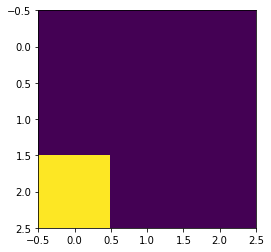

In [182]:
game = Game(*Game.create_arena(arena_shape, agents.keys(), coin_count=1))
plt.imshow(game.coins)

1 1
[ 0.27705956  0.2829157   0.16659524  0.16099712 -0.07915533 -0.04103767]
[1.35621488 1.36207104 1.24575055 1.24015248 0.         0.        ]
LEFT {'tensor_agent': 0}


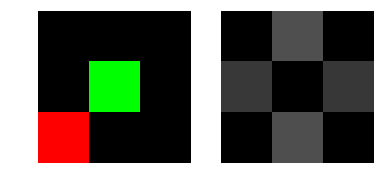

In [183]:
actions = {}
Xs = {}
for agent in game.agents:
    x, y, name, _, _ = agent

    Xs[name] = game.get_X(x, y)
    valid_actions = get_valid_actions(x, y, game)
    
    print(x, y)
    pred = agents[name].model.online.predict(np.array([Xs[name]]))[0]
    print(pred)
    if valid_actions is not None:
        pred = valid_actions * (pred - np.min(pred) + 1)

    print(pred)
    action_choice = np.argmax(pred)
            
    actions[name] = action_choice

actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
#actions_as_string['tensor_agent'] = 'RIGHT'
rewards = game.step(actions_as_string)

print(actions_as_string['tensor_agent'], rewards)

#img = np.zeros((input_shape[0], input_shape[1], 3))
#img[:,:,0] = Xs['tensor_agent'][:,:,0]
#img[arena_shape[0]-1,arena_shape[1]-1,1] = 1

img = np.zeros((arena_shape[0], arena_shape[0], 3))
img[:,:,0] = game.coins
img[x,y,1] = 1


choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
choice_dict = {choices[i]: i for i in range(len(choices))}

a = np.zeros((3, 3))
a[2, 1] = pred[choice_dict['RIGHT']]
a[0, 1] = pred[choice_dict['LEFT']]
a[1, 0] = pred[choice_dict['UP']]
a[1, 2] = pred[choice_dict['DOWN']]
a[1, 1] = pred[choice_dict['WAIT']]
a[0, 0] = pred[choice_dict['BOMB']]

#a = np.exp(a) / np.sum(np.exp(a), axis=0)
a = np.log(a + 0.0001)
a[a == -np.inf] = 0

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.axis('off')
ax2.axis('off')
ax2.imshow(a, cmap='gray', vmin=0, vmax=1)
ax1.imshow(img)

In [56]:
game.agents[0] = (0,2,'tensor_agent',1,0)

In [8]:
pred, grd = K.get_session().run([model.t_out, grads], feed_dict={
            model.input_ph: np.array([Xs['tensor_agent']])
        })

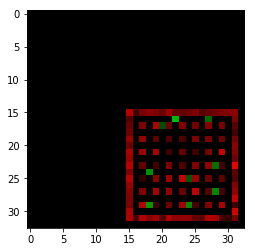

In [21]:
img0 = grd[0][0][:,:,0:1]
img0 = img0 - np.min(img0)
img0 = img0 / np.max(img0)

img1 = grd[0][0][:,:,1:2]
img1 = img1 - np.min(img1)
img1 = img1 / np.max(img1)

img5 = grd[0][0][:,:,5:6]
img5 = img5 - np.min(img5)
img5 = img5 / np.max(img5)

inp = Xs['tensor_agent'][:,:,[0,5,1]]
img = np.concatenate([img0, img5, img1], axis=2)


plt.imshow(img * inp)

In [6]:
class FrozenLake:
    def __init__(self, coins, agents):
        self.shape = coins.shape
        self.agents = agents
        self.coins = coins
        self.steps = 0
        self.terminated = False
    
    @staticmethod
    def create_arena(shape, agent_names):
        lake = np.zeros(shape)
        xs = np.random.choice(shape[0], 1)
        ys = np.random.choice(shape[1], 1)
        
        lake[xs, ys] = 1
        
        while np.min(lake) > -1:
            xs = np.random.choice(shape[0], 1)
            ys = np.random.choice(shape[1], 1)
            if lake[xs, ys] != 1:
                lake[xs, ys] = -1
        
        
        # Distribute starting positions
        xs = np.random.choice(shape[0], len(agent_names))
        ys = np.random.choice(shape[1], len(agent_names))
        agents = []
        for name in agent_names:
            x, y = np.random.choice(shape[0]), np.random.choice(shape[1])
            agents.append((x, y, name, 1, 0))
        
        return [lake, agents]
    
    def step(self, agent_actions, permutation=None):
        self.steps += 1

        if permutation is None:
            permutation = np.random.permutation(len(self.agents))

        step_score = {n: 0 for _,_,n,_,_ in self.agents}

        for j in range(len(self.agents)):
            agent = self.agents[permutation[j]]
            x, y, name, bombs_left, score = agent
            action = agent_actions[name]
            
            if action == 'DOWN' and self.tile_is_free(x, y+1):
                y += 1
            if action == 'UP' and self.tile_is_free(x, y-1):
                y -= 1
            if action == 'RIGHT' and self.tile_is_free(x+1, y):
                x += 1
            if action == 'LEFT' and self.tile_is_free(x-1, y):
                x -= 1
            
            self.agents[permutation[j]] = (x, y, name, bombs_left, score)
        
        
        for j in range(len(self.agents)):
            x, y, name, bombs_left, score = self.agents[j]
            if self.coins[x,y]==1:
                step_score[name]+=s.reward_coin
            self.coins[x,y]=0
        
        if np.all(self.coins == 0) or len(self.agents) == 0 or self.steps >= 40:
            self.terminated = True
        
        return step_score
    
    def get_X(self, x, y):
        X = np.zeros((self.shape[0] * 2 - 1, self.shape[1] * 2 - 1, 1))
        X[self.shape[0]-1-x:self.shape[0]*2-1-x, self.shape[1]-1-y:self.shape[1]*2-1-y, 0] = self.coins
        return X
        
    def tile_is_free(self, x, y):
        ax, ay = self.shape
        if x < 0 or x >= ax or y < 0 or y >= ay:
            return False
        return True
    